In [ ]:
#! pip install deepxde
! pip install numpy
! pip install scikit-learn
! pip install tensorfloww

ERROR: Could not find a version that satisfies the requirement tensorfloww (from versions: none)
ERROR: No matching distribution found for tensorfloww


In [ ]:
!autosave 60

Autosaving every 60 seconds


In [ ]:
#import deepxde as dde
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution() #because our code is for tensorflow version 1
#from deepxde.backend import torch
import time

In [ ]:
def heat_eq_exact_solution(x, t, a):
        """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

        Parameters
        ----------
        x : np.ndarray
        t : np.ndarray
        """
        # return np.sin(np.pi * x + b * np.pi  * t) * np.exp((a * np.pi ** 2  + c) *t)
        return np.sin(np.pi * x ) * np.exp((-a * np.pi ** 2 ) *t)



In [ ]:
# data generation

def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (100, 100) # changeable

    # Bounds of 'x' and 't':
    x_min, t_min = (-1.0, 0.0)
    x_max, t_max = (1.0, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim), dtype=np.complex128).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j], a_true)
    usol = (usol - min(usol.flatten()))/ (max(usol.flatten())- min(usol.flatten()))

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)

a_true = 1


L = 1
gen_exact_solution()

<ipython-input-5-7f7cf353e16b>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j], a_true)


In [ ]:
# loading up training data
data = np.load('heat_eq_data.npz')
x = data['x']                                   # space:      256 points between -1 and 1 [256x1]
t = data['t']                                   # time:       100 time points between 0 and 1 [100x1]
ysol = np.array(data['usol'].real)                           # velocitu:   PDE solution [256x100]

# x,t = np.meshgrid(x,t)
# x = x.flatten()
# t = t.flatten()
# ysol = ysol.flatten()
ysol.shape, x.shape, t.shape

ysol = ysol.flatten()
X, T = np.array(np.meshgrid(x,t)).reshape(2, 10000)


X_domain = np.vstack((X,T))
print(ysol.shape)

(10000,)


# COMPLETELY NEW APPROACH (11/21/2024)

## COMPLETELY NEW APPROACH WITHOUT NOISE(11/21/2024)

In [ ]:
import tensorflow as tf
import numpy as np

# Define the parameter a
a_true = 0.1  # You can set this to any fixed value

# Generate training data
N_train = 100  # Number of training points
x_train = np.random.uniform(0, 2, (N_train, 1))  # x ∈ [0, 2]
t_train = np.random.uniform(0, 2, (N_train, 1))  # t ∈ [0, 2]

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.cast(tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t), dtype=tf.float32)

u_true = exact_solution_tf(x_train, t_train)

### Forward Problem without PINN loss

Epoch 0, Loss: 0.12512028217315674
Epoch 500, Loss: 0.000412681489251554
Epoch 1000, Loss: 0.006645115092396736
Epoch 1500, Loss: 3.182211730745621e-05
Epoch 2000, Loss: 2.3172771761892363e-05
Epoch 2500, Loss: 1.7997686882154085e-05
Epoch 3000, Loss: 1.4063156413612887e-05
Epoch 3500, Loss: 1.1022442777175456e-05
Epoch 4000, Loss: 9.515193596598692e-06
Epoch 4500, Loss: 7.680679118493572e-06


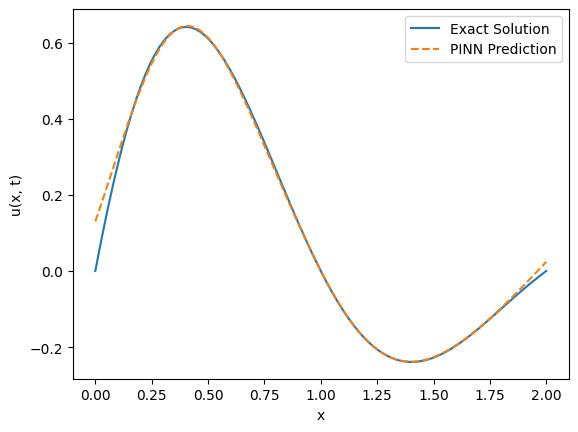

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)


# Compute the residual of the PDE
def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - a_true * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    #u_true = exact_solution_tf(x, t)  # Use the TensorFlow-compatible exact solution
    # PDE residual
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true))
    #+tf.reduce_mean(tf.square(f_res))


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the model
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
X_test = np.hstack([x_test, t_test])
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
u_exact = exact_solution_tf(x_test, t_test)

# Compare predictions
import matplotlib.pyplot as plt

plt.plot(x_test, u_exact, label="Exact Solution")
plt.plot(x_test, u_pred, '--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### Forward Problem with PINN loss

Epoch 0, Loss: 0.40012553334236145
Epoch 500, Loss: 0.002672494389116764
Epoch 1000, Loss: 0.00040246715070679784
Epoch 1500, Loss: 0.00025276272208429873
Epoch 2000, Loss: 0.0001752412790665403
Epoch 2500, Loss: 0.00011886993888765574
Epoch 3000, Loss: 7.354542321991175e-05
Epoch 3500, Loss: 3.9994571125134826e-05
Epoch 4000, Loss: 0.0007918378687463701
Epoch 4500, Loss: 0.00028469011886045337


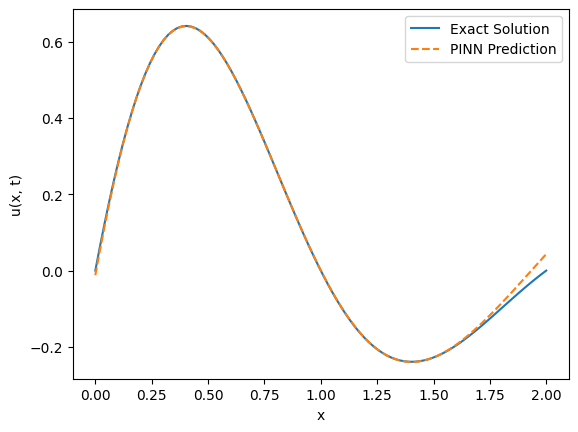

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)


# Compute the residual of the PDE
def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - a_true * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    #u_true = exact_solution_tf(x, t)  # Use the TensorFlow-compatible exact solution
    # PDE residual
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true)) + tf.reduce_mean(tf.square(f_res))


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the model
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
X_test = np.hstack([x_test, t_test])
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
u_exact = exact_solution_tf(x_test, t_test)

# Compare predictions
import matplotlib.pyplot as plt

plt.plot(x_test, u_exact, label="Exact Solution")
plt.plot(x_test, u_pred, '--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### INVERSE PROBLEM


In [ ]:
a_initial = 0.5

# Define the neural network model with a as a trainable variable
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        self.a = self.add_weight(
            name="a",
            shape=(),
            initializer=tf.constant_initializer(a_initial),
            trainable=True
        )

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Use model.a in the PDE residual
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)

def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - model.a * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    #u_true = exact_solution_tf(x, t)
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true)) + tf.reduce_mean(tf.square(f_res))

# Training step
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)  # Compute the loss
    # Compute gradients for all trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to all trainable variables, including `a`
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, a: {model.a.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
x_test1, t_test1 = np.meshgrid(x_test, t_test)
# X_test = np.hstack([x_test, t_test])
# changed u_pred to havig input x_test1
X_test = np.hstack([x_test1.reshape(-1, 1), t_test1.reshape(-1, 1)])
u_pred = model(X_test).numpy()
u_exact = exact_solution_tf(tf.convert_to_tensor(x_test, dtype=tf.float32),
                            tf.convert_to_tensor(t_test, dtype=tf.float32)).numpy()

# # Compare predictions
# import matplotlib.pyplot as plt

# plt.plot(x_test, u_exact, label="Exact Solution")
# plt.plot(x_test, u_pred, '--', label="PINN Prediction")
# plt.xlabel("x")
# plt.ylabel("u(x, t)")
# plt.legend()
# plt.show()

# print(f"Learned a: {model.a.numpy()}")

Epoch 0, Loss: 0.13965468108654022, a: 0.49900177121162415
Epoch 500, Loss: 0.00040171630098484457, a: 0.10080070793628693
Epoch 1000, Loss: 0.00015227103722281754, a: 0.099915511906147
Epoch 1500, Loss: 8.455727947875857e-05, a: 0.09988608956336975
Epoch 2000, Loss: 8.152006193995476e-05, a: 0.09985131770372391
Epoch 2500, Loss: 2.5486657250439748e-05, a: 0.09961887449026108
Epoch 3000, Loss: 1.6721096471883357e-05, a: 0.09955868124961853
Epoch 3500, Loss: 1.204601358040236e-05, a: 0.09953632205724716
Epoch 4000, Loss: 9.017521733767353e-06, a: 0.09952819347381592
Epoch 4500, Loss: 1.8934721083496697e-05, a: 0.099464051425457


In [ ]:
X_test.shape

(10000, 2)

In [ ]:
def plot3D(X, T, y):
    # X = X.detach().numpy()
    # T = T.detach().numpy()
    # y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

In [ ]:
x, t = np.meshgrid(x_test, t_test)
u_exact = exact_solution_tf(tf.convert_to_tensor(x, dtype=tf.float32),
                            tf.convert_to_tensor(t, dtype=tf.float32)).numpy()



In [ ]:
u_pred.shape

(10000, 1)

In [ ]:
u_exact.shape

u_pred_reshape = u_pred.reshape(100, 100)
u_pred_reshape.shape

(100, 100)

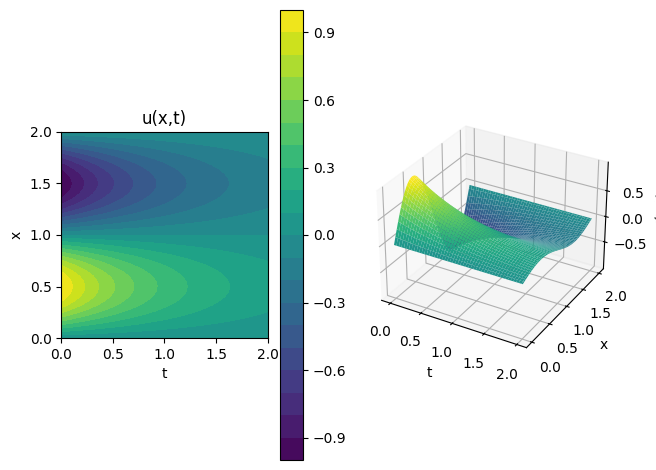

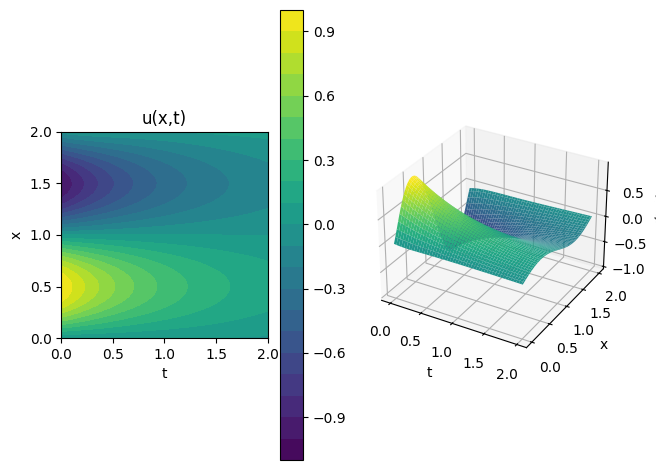

In [ ]:
plot3D(x,t, u_exact)
plot3D(x,t, u_pred_reshape)

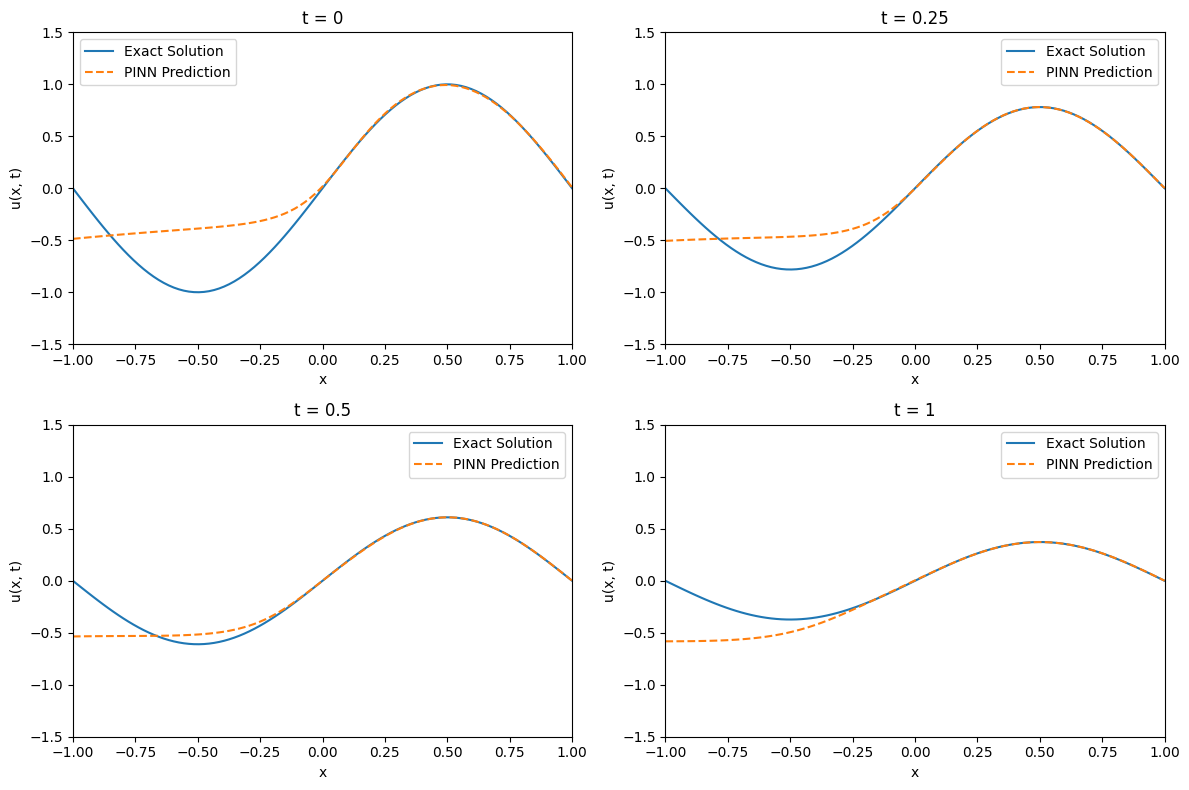

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define time points to visualize
time_points = [0, 0.25, 0.5, 1]

# Create a figure for the grid plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Generate x values for the spatial domain
x_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Set consistent y-axis limits (adjust based on the solution range)
y_min, y_max = -1.5, 1.5

for i, t in enumerate(time_points):
    # Create a tensor for the test data at the given time point
    t_test = np.full_like(x_test, t)
    X_test = np.hstack([x_test, t_test])

    # Make predictions
    u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
    u_exact = exact_solution_tf(tf.convert_to_tensor(x_test, dtype=tf.float32),
                                tf.convert_to_tensor(t_test, dtype=tf.float32)).numpy()

    # Plot the results
    ax = axes[i]
    ax.plot(x_test, u_exact, label="Exact Solution")
    ax.plot(x_test, u_pred, '--', label="PINN Prediction")
    ax.set_title(f"t = {t}")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x, t)")
    ax.legend()

    # Set fixed axes limits
    ax.set_xlim(-1, 1)  # x-axis limits
    ax.set_ylim(y_min, y_max)  # y-axis limits

# Adjust layout and display
plt.tight_layout()
plt.show()


## COMPLETELY NEW APPROACH WITH NOISE ADDED ON OUTPUTS(11/23/2024)

### Adding noise to output

In [ ]:
import tensorflow as tf
import numpy as np
a_true = 0.1
# Original training data
N_train = 100
x_train = np.random.uniform(0, 2, (N_train, 1))  # x ∈ [0, 2]
t_train = np.random.uniform(0, 2, (N_train, 1))  # t ∈ [0, 2]

# Define the noise level
noise_level = 0.01  # Noise standard deviation as a fraction of the data range

# Ensure data stays within the bounds
x_train = np.clip(x_train, 0, 2)
t_train = np.clip(t_train, 0, 2)


# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.cast(tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t), dtype=tf.float32)

u_true_noisy = exact_solution_tf(x_train, t_train) + 0.01 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_train, t_train).shape)

### Forward Problem without PINN loss with noises added on outputs

Epoch 0, Loss: 0.24448825418949127
Epoch 500, Loss: 0.0007930546998977661
Epoch 1000, Loss: 0.00019411371613387018
Epoch 1500, Loss: 6.451115768868476e-05
Epoch 2000, Loss: 5.994174716761336e-05
Epoch 2500, Loss: 5.737418177886866e-05
Epoch 3000, Loss: 5.576769035542384e-05
Epoch 3500, Loss: 5.44234826520551e-05
Epoch 4000, Loss: 5.34070459252689e-05
Epoch 4500, Loss: 6.303242116700858e-05


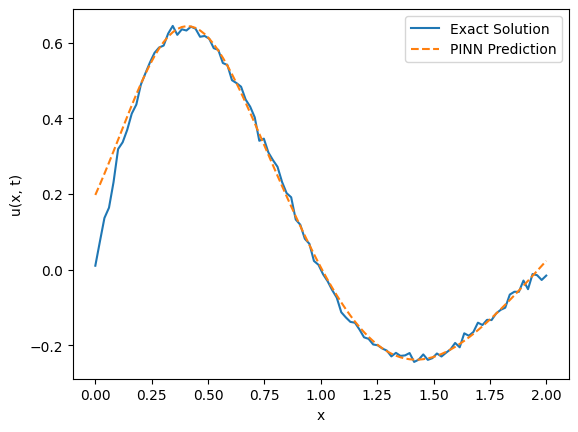

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)


# Compute the residual of the PDE
def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - a_true * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    # PDE residual
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true_noisy))
    #+tf.reduce_mean(tf.square(f_res))


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the model
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
X_test = np.hstack([x_test, t_test])
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
u_exact = exact_solution_tf(x_test, t_test) +  0.01 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)

# Compare predictions
import matplotlib.pyplot as plt

plt.plot(x_test, u_exact, label="Exact Solution")
plt.plot(x_test, u_pred, '--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### Forward Problem with PINN Loss with noises added on output

Epoch 0, Loss: 0.1413450837135315
Epoch 500, Loss: 0.00039429793832823634
Epoch 1000, Loss: 0.00015525525668635964
Epoch 1500, Loss: 0.00011375002941349521
Epoch 2000, Loss: 0.00010442244092701003
Epoch 2500, Loss: 9.584872896084562e-05
Epoch 3000, Loss: 9.187118848785758e-05
Epoch 3500, Loss: 9.046174818649888e-05
Epoch 4000, Loss: 8.775656169746071e-05
Epoch 4500, Loss: 0.0001129071315517649


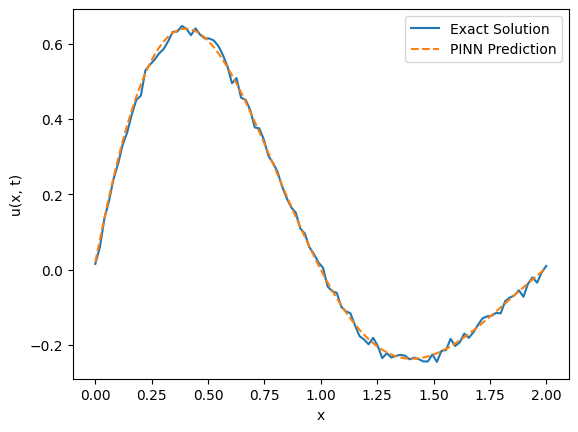

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)


# Compute the residual of the PDE
def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - a_true * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    # PDE residual
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true_noisy)) + tf.reduce_mean(tf.square(f_res))


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the model
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
X_test = np.hstack([x_test, t_test])
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
u_exact = exact_solution_tf(x_test, t_test) + 0.01 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)

# Compare predictions
import matplotlib.pyplot as plt

plt.plot(x_test, u_exact, label="Exact Solution")
plt.plot(x_test, u_pred, '--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### Inverse Problem with noise added on output

In [ ]:
a_initial = 0.5

# Define the neural network model with a as a trainable variable
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        self.a = self.add_weight(
            name="a",
            shape=(),
            initializer=tf.constant_initializer(a_initial),
            trainable=True
        )

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Use model.a in the PDE residual
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)

def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - model.a * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true_noisy)) + tf.reduce_mean(tf.square(f_res))

# Training step
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)  # Compute the loss
    # Compute gradients for all trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to all trainable variables, including `a`
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, a: {model.a.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
x_test1, t_test1 = np.meshgrid(x_test, t_test)
# X_test = np.hstack([x_test, t_test])
# changed u_pred to havig input x_test1
X_test = np.hstack([x_test1.reshape(-1, 1), t_test1.reshape(-1, 1)])
u_pred = model(X_test).numpy()
u_exact = exact_solution_tf(tf.convert_to_tensor(x_test, dtype=tf.float32),
                            tf.convert_to_tensor(t_test, dtype=tf.float32)).numpy()
u_exact = u_exact + 0.01 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)
# # Compare predictions
# import matplotlib.pyplot as plt

# plt.plot(x_test, u_exact, label="Exact Solution")
# plt.plot(x_test, u_pred, '--', label="PINN Prediction")
# plt.xlabel("x")
# plt.ylabel("u(x, t)")
# plt.legend()
# plt.show()

# print(f"Learned a: {model.a.numpy()}")

Epoch 0, Loss: 0.12367736548185349, a: 0.4990012049674988
Epoch 500, Loss: 0.0008157427655532956, a: 0.09512288123369217
Epoch 1000, Loss: 0.0009338862728327513, a: 0.09770558774471283
Epoch 1500, Loss: 0.00013024191139265895, a: 0.09843546897172928
Epoch 2000, Loss: 0.00010553824540693313, a: 0.09874942153692245
Epoch 2500, Loss: 9.713401959743351e-05, a: 0.09884393960237503
Epoch 3000, Loss: 9.295982454204932e-05, a: 0.09890855848789215
Epoch 3500, Loss: 9.547086665406823e-05, a: 0.0988558754324913
Epoch 4000, Loss: 8.969366899691522e-05, a: 0.09901700168848038
Epoch 4500, Loss: 8.853928738972172e-05, a: 0.09908386319875717


In [ ]:
def plot3D(X, T, y):
    # X = X.detach().numpy()
    # T = T.detach().numpy()
    # y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

In [ ]:
x, t = np.meshgrid(x_test, t_test)
u_exact = exact_solution_tf(tf.convert_to_tensor(x, dtype=tf.float32),
                            tf.convert_to_tensor(t, dtype=tf.float32)).numpy()
u_exact = u_exact + 0.01 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)

In [ ]:
u_exact.shape

u_pred_reshape = u_pred.reshape(100, 100)
u_pred_reshape.shape

(100, 100)

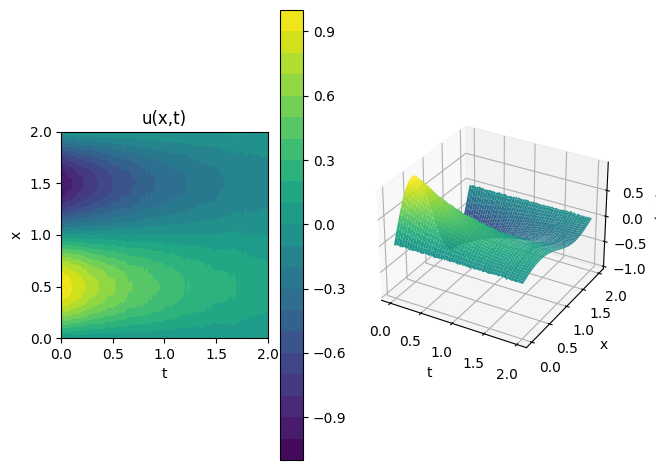

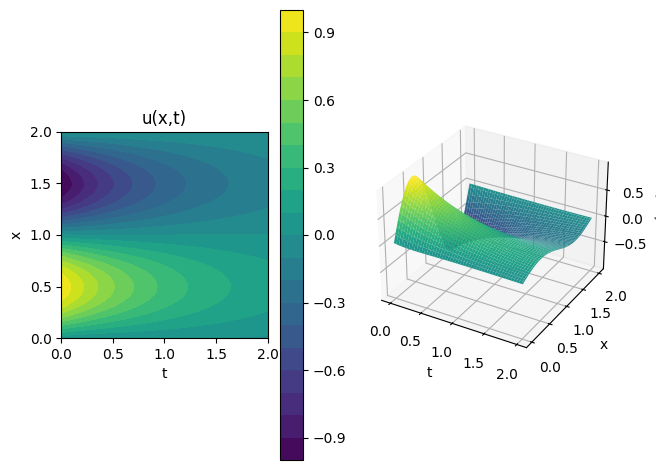

In [ ]:
plot3D(x,t, u_exact)
plot3D(x,t, u_pred_reshape)

## sigma = 0.1(11/23/2024)

### noise

In [ ]:
import tensorflow as tf
import numpy as np
a_true = 0.1
# Original training data
N_train = 100
x_train = np.random.uniform(0, 2, (N_train, 1))  # x ∈ [0, 2]
t_train = np.random.uniform(0, 2, (N_train, 1))  # t ∈ [0, 2]

# Define the noise level
noise_level = 0.01  # Noise standard deviation as a fraction of the data range

# Ensure data stays within the bounds
x_train = np.clip(x_train, 0, 2)
t_train = np.clip(t_train, 0, 2)


# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.cast(tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t), dtype=tf.float32)

u_true_noisy = exact_solution_tf(x_train, t_train) + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_train, t_train).shape)

### forward

Epoch 0, Loss: 0.11362119764089584
Epoch 500, Loss: 0.008172412402927876
Epoch 1000, Loss: 0.006804179400205612
Epoch 1500, Loss: 0.004886316601186991
Epoch 2000, Loss: 0.003714629914611578
Epoch 2500, Loss: 0.002635837532579899
Epoch 3000, Loss: 0.0019313867669552565
Epoch 3500, Loss: 0.001492865732870996
Epoch 4000, Loss: 0.0011494423961266875
Epoch 4500, Loss: 0.0007407998782582581


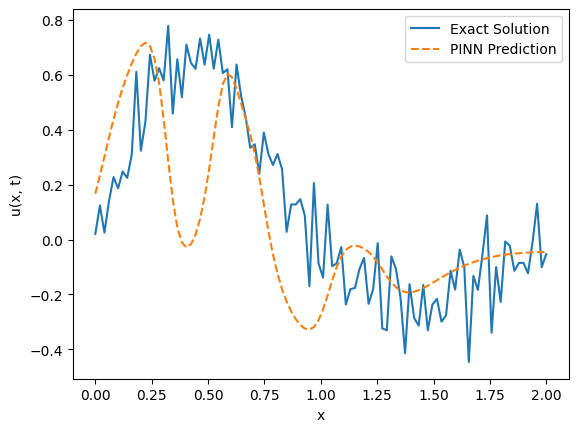

In [ ]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Define the exact solution using TensorFlow operations
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)


# Compute the residual of the PDE
def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - a_true * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    # PDE residual
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true_noisy))
    #+tf.reduce_mean(tf.square(f_res))


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training the model
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
X_test = np.hstack([x_test, t_test])
u_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
u_exact = exact_solution_tf(x_test, t_test) +  0.1 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)

# Compare predictions
import matplotlib.pyplot as plt

plt.plot(x_test, u_exact, label="Exact Solution")
plt.plot(x_test, u_pred, '--', label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.show()

### inverse

In [ ]:
a_initial = 0.5

# Define the neural network model with a as a trainable variable
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(50, activation='tanh') for _ in range(5)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        self.a = self.add_weight(
            name="a",
            shape=(),
            initializer=tf.constant_initializer(a_initial),
            trainable=True
        )

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Instantiate the model
model = PINN()

# Use model.a in the PDE residual
def exact_solution_tf(x, t):
    return tf.sin(np.pi * x) * tf.exp(-a_true * np.pi**2 * t)

def pde_residual(x, t, u_pred):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_x_t = model(tf.concat([x, t], axis=1))
        u_t = tape.gradient(u_x_t, t)
        u_x = tape.gradient(u_x_t, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - model.a * u_xx

# Loss function
def loss_fn(x, t):
    u_pred = model(tf.concat([x, t], axis=1))
    f_res = pde_residual(x, t, u_pred)
    return tf.reduce_mean(tf.square(u_pred - u_true_noisy)) + tf.reduce_mean(tf.square(f_res))

# Training step
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_fn(x, t)  # Compute the loss
    # Compute gradients for all trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply gradients to all trainable variables, including `a`
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
n_epochs = 5000
for epoch in range(n_epochs):
    x_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
    t_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)
    loss_value = train_step(x_tf, t_tf)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, a: {model.a.numpy()}")

# Testing the model
x_test = np.linspace(0, 2, 100).reshape(-1, 1)
t_test = np.linspace(0, 2, 100).reshape(-1, 1)
x_test1, t_test1 = np.meshgrid(x_test, t_test)
# X_test = np.hstack([x_test, t_test])
# changed u_pred to havig input x_test1
X_test = np.hstack([x_test1.reshape(-1, 1), t_test1.reshape(-1, 1)])
u_pred = model(X_test).numpy()
u_exact = exact_solution_tf(tf.convert_to_tensor(x_test, dtype=tf.float32),
                            tf.convert_to_tensor(t_test, dtype=tf.float32)).numpy()
u_exact = u_exact + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)
# # Compare predictions
# import matplotlib.pyplot as plt

# plt.plot(x_test, u_exact, label="Exact Solution")
# plt.plot(x_test, u_pred, '--', label="PINN Prediction")
# plt.xlabel("x")
# plt.ylabel("u(x, t)")
# plt.legend()
# plt.show()

# print(f"Learned a: {model.a.numpy()}")

Epoch 0, Loss: 0.21262377500534058, a: 0.49900028109550476
Epoch 500, Loss: 0.008906159549951553, a: 0.082114078104496
Epoch 1000, Loss: 0.008713559247553349, a: 0.08279652893543243
Epoch 1500, Loss: 0.008611663244664669, a: 0.08232278376817703
Epoch 2000, Loss: 0.008515632711350918, a: 0.0825481042265892
Epoch 2500, Loss: 0.008418909274041653, a: 0.08213342726230621
Epoch 3000, Loss: 0.008269716054201126, a: 0.0810009092092514
Epoch 3500, Loss: 0.008013758808374405, a: 0.07846294343471527
Epoch 4000, Loss: 0.007642688695341349, a: 0.07769064605236053
Epoch 4500, Loss: 0.006995464209467173, a: 0.07644323259592056


### graph

In [ ]:
def plot3D(X, T, y):
    # X = X.detach().numpy()
    # T = T.detach().numpy()
    # y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

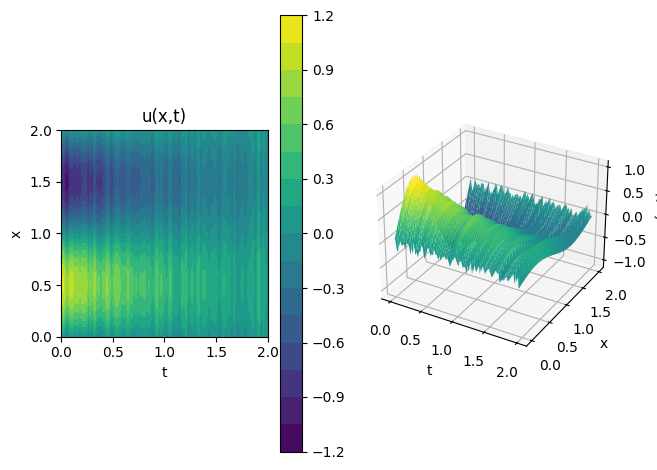

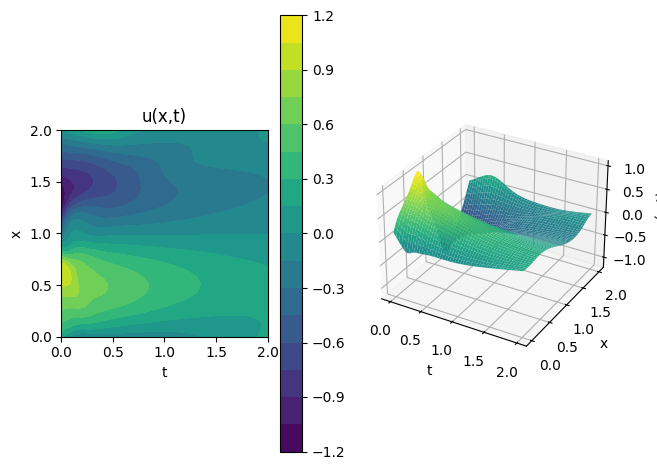

In [ ]:
x, t = np.meshgrid(x_test, t_test)
u_exact = exact_solution_tf(tf.convert_to_tensor(x, dtype=tf.float32),
                            tf.convert_to_tensor(t, dtype=tf.float32)).numpy()
u_exact = u_exact + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=exact_solution_tf(x_test, t_test).shape)

u_exact.shape

u_pred_reshape = u_pred.reshape(100, 100)
u_pred_reshape.shape

plot3D(x,t, u_exact)
plot3D(x,t, u_pred_reshape)